In [9]:
import numpy as np
import pickle
import cv2
import os
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pylab as plt
import seaborn as sns
import sklearn

In [10]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 100

# Path to the dataset folder
root_dir = './PlantVillage'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'valid')

In [11]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [12]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Healthy ...
[INFO] Processing RedRot ...
[INFO] Processing RedRust ...
[INFO] Image loading completed

Total number of images: 224


In [13]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  3


In [15]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

In [16]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


In [52]:
EPOCHS = 50
STEPS = 10
LR = 1e-3
BATCH_SIZE = 16
WIDTH = 256
HEIGHT = 256
DEPTH = 3

In [53]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()
# model.cuda()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 activation_14 (Activation)  (None, 256, 256, 32)      0         
                                                                 
 batch_normalization_12 (Bat  (None, 256, 256, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 85, 85, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 85, 85, 64)       

In [15]:
model = keras.models.load_model(r'acc\effic_model_76')

In [54]:
# Initialize optimizer
opt = Adam(lr=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_train, y_train),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

C:\Users\rathn\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[INFO] Training network...


C:\Users\rathn\AppData\Local\Temp\ipykernel_30116\3875615172.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),


Epoch 1/50
11/11 [==============================] - 21s 2s/step - loss: 0.8142 - accuracy: 0.6748 - val_loss: 1.7887 - val_accuracy: 0.3128
Epoch 2/50
11/11 [==============================] - 20s 2s/step - loss: 0.4912 - accuracy: 0.8221 - val_loss: 5.3560 - val_accuracy: 0.3128
Epoch 3/50
11/11 [==============================] - 18s 2s/step - loss: 0.3494 - accuracy: 0.8957 - val_loss: 8.3895 - val_accuracy: 0.3128
Epoch 4/50
11/11 [==============================] - 17s 2s/step - loss: 0.2239 - accuracy: 0.9141 - val_loss: 12.6192 - val_accuracy: 0.3128
Epoch 5/50
11/11 [==============================] - 17s 2s/step - loss: 0.2000 - accuracy: 0.9264 - val_loss: 14.5335 - val_accuracy: 0.4637
Epoch 6/50
11/11 [==============================] - 17s 2s/step - loss: 0.2585 - accuracy: 0.9141 - val_loss: 6.0283 - val_accuracy: 0.3352
Epoch 7/50
11/11 [==============================] - 17s 2s/step - loss: 0.2759 - accuracy: 0.8957 - val_loss: 1.2154 - val_accuracy: 0.5419
Epoch 8/50
11/11 [

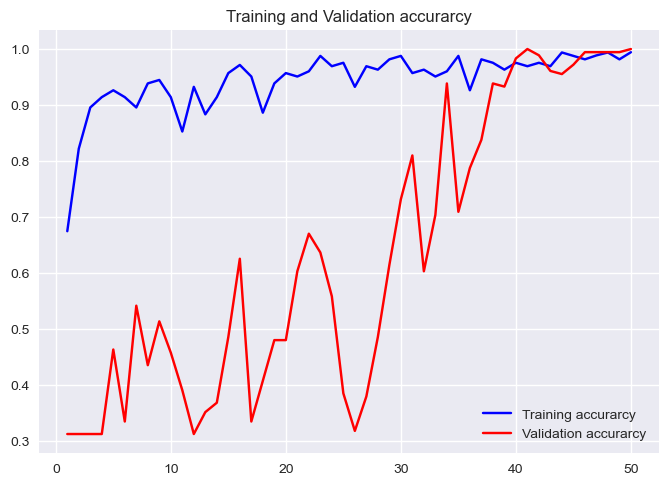

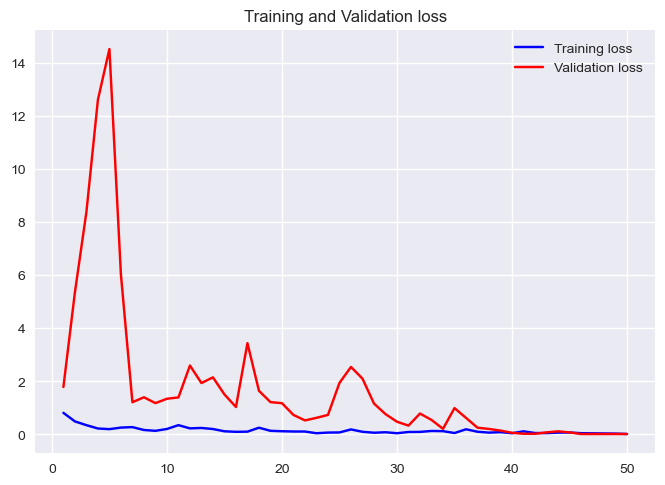

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Evaluating model accuracy by using the `evaluate` method

In [56]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_train, y_train)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 3s 426ms/step - loss: 0.0154 - accuracy: 1.0000
Test Accuracy: 100.0


In [57]:
print("[INFO] Saving model...")
pickle.dump(model,open('plant_disease_classification_model.pkl', 'wb'))

[INFO] Saving model...
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\activation_1
......vars
...layers\activation_2
......vars
...layers\activation_3
......vars
...layers\activation_4
......vars
...layers\activation_5
......vars
...layers\activation_6
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_1
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_2
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_3
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_4
......vars
.........0
.........1
.........2
.........3
...layers\batch_normalization_5
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\conv2d_2
......vars
.........0
.........1
.

In [58]:
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


# Test Model


We write the following `predict_disease` function to predict the class or disease of a plant image. 

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [59]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = np.argmax(model.predict(np_image), axis=-1)
    print(result)
    print((image_labels.classes_[result][0]))

For testing purposes, we randomly choose images from the dataset and try predicting class or disease of the plant image.

1/1 [==============================] - 0s 281ms/step
[1]
RedRot


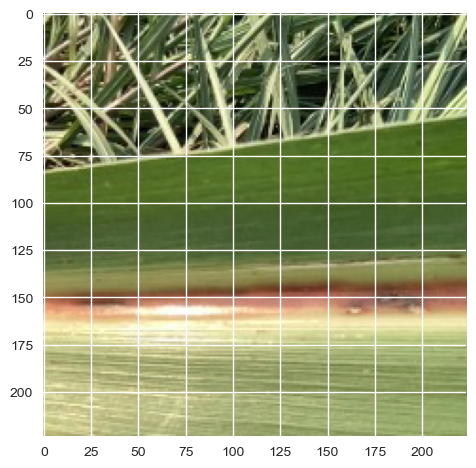

In [60]:
predict_disease(r'PlantVillage\train\RedRot\1.jpg')

1/1 [==============================] - 0s 70ms/step
[1]
RedRot


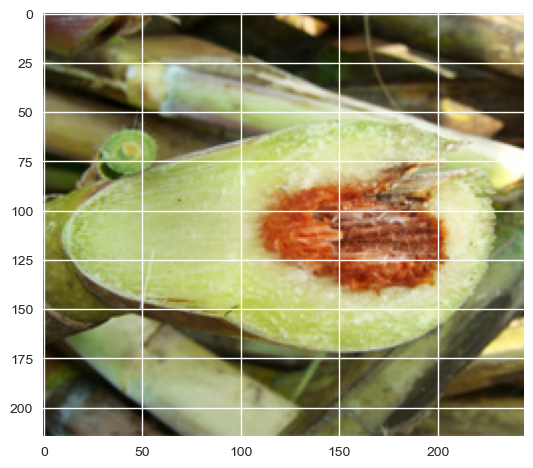

In [61]:
predict_disease(r'PlantVillage\train\RedRot\7.jpg')

1/1 [==============================] - 0s 71ms/step
[0]
Healthy


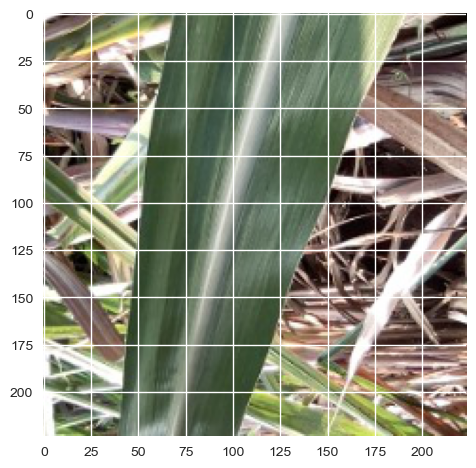

In [62]:
predict_disease(r'PlantVillage\train\Healthy\2.jpg')

1/1 [==============================] - 0s 59ms/step
[2]
RedRust


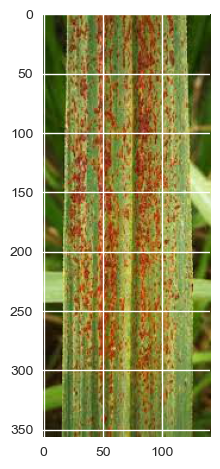

In [63]:
predict_disease(r'PlantVillage\train\RedRust\74.jpg')

1/1 [==============================] - 0s 76ms/step
[2]
RedRust


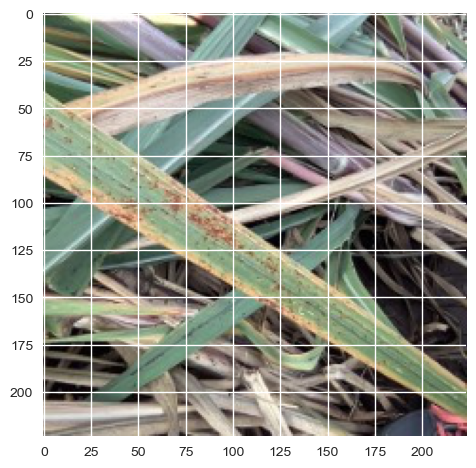

In [64]:
predict_disease(r'PlantVillage\train\RedRust\71.jpg')

In [65]:
model.save('C:/Users/rathn/Desktop/DL/Soft Computing/plant-disease-detection/acc/effic_model_76')

INFO:tensorflow:Assets written to: C:/Users/rathn/Desktop/DL/Soft Computing/plant-disease-detection/acc/effic_model_76\assets


INFO:tensorflow:Assets written to: C:/Users/rathn/Desktop/DL/Soft Computing/plant-disease-detection/acc/effic_model_76\assets


In [72]:
y_pred = model.predict(x_test)

2/2 [==============================] - 1s 158ms/step


In [77]:
y_test_binary = y_test.argmax(axis=1)
y_pred_binary = model.predict(x_test)
y_pred_binary = y_pred_binary.argmax(axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
print(cm)

2/2 [==============================] - 1s 179ms/step
[[12  0  0]
 [ 0 16  2]
 [ 0  0 15]]


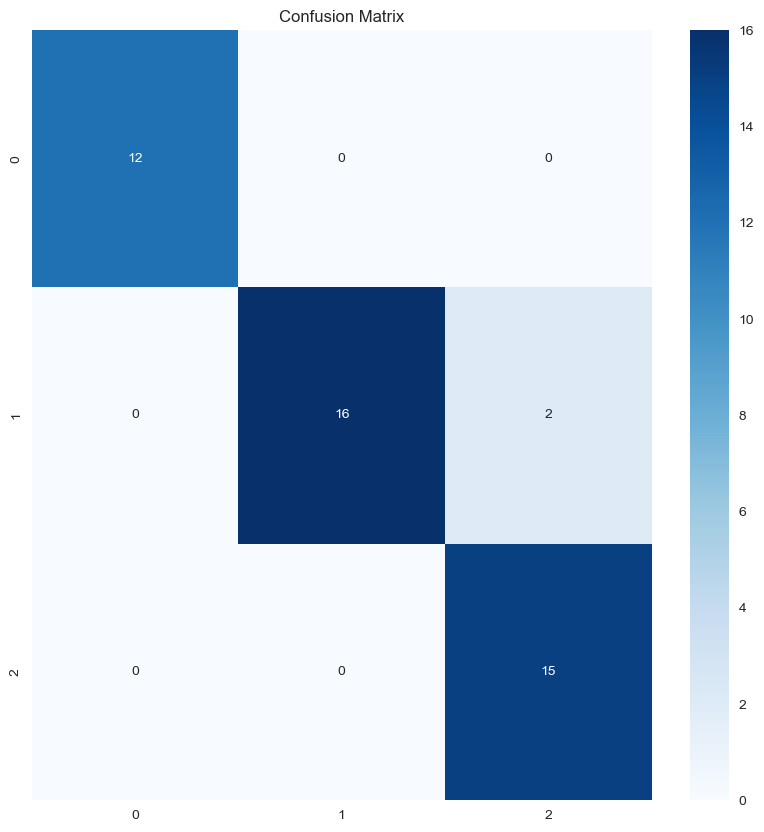

0 -> Healthy 

1 -> RedRot 

2 -> RedRust 



In [79]:

plt.style.use("seaborn")
plt.figure(figsize=(10,10))
heat_map = sns.heatmap( cm, cmap=plt.cm.Blues, annot = True)
plt.title( "Confusion Matrix" )
plt.show()

final_list = list(set(label_list))
for i in range(len(final_list)):
    print(i,"->",final_list[i],"\n")

In [83]:
for img_file in os.listdir(r"PlantVillage\valid\RedRot"):
    # read the image
    img = cv2.imread(os.path.join(r"PlantVillage\valid\RedRot", img_file))

    # resize the image to match the input size of the model
    img = cv2.resize(img, (256, 256))

    # normalize the pixel values
    img = img.astype("float32") / 255.0

    # add a new dimension to the image to match the input shape of the model
    img = np.expand_dims(img, axis=0)

    # use the model to predict the class label
    pred = model.predict(img)

    # print the predicted class label
    print("Image: ", img_file, "Prediction: ", pred.argmax(axis=1))

1/1 [==============================] - 0s 63ms/step
Image:  0.jpg Prediction:  [1]
1/1 [==============================] - 0s 53ms/step
Image:  1.jpg Prediction:  [1]
1/1 [==============================] - 0s 50ms/step
Image:  10.jpg Prediction:  [1]
1/1 [==============================] - 0s 50ms/step
Image:  11.jpg Prediction:  [1]
1/1 [==============================] - 0s 54ms/step
Image:  12.jpg Prediction:  [1]
1/1 [==============================] - 0s 69ms/step
Image:  13.jpg Prediction:  [1]
1/1 [==============================] - 0s 69ms/step
Image:  14.jpg Prediction:  [1]
1/1 [==============================] - 0s 60ms/step
Image:  15.jpg Prediction:  [1]
1/1 [==============================] - 0s 56ms/step
Image:  16.jpg Prediction:  [1]
1/1 [==============================] - 0s 53ms/step
Image:  17.jpg Prediction:  [1]
1/1 [==============================] - 0s 52ms/step
Image:  18.jpg Prediction:  [0]
1/1 [==============================] - 0s 54ms/step
Image:  19.jpg Prediction: